# Preliminary

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
import sys

import numpy as np
import pickle, random, string
import matplotlib.pyplot as plt
%matplotlib inline

# Visualization
from IPython.display import display

from pathlib import Path

In [2]:
# Ugly patch becasue idk how to make this propperly work
#sys.path[0] += '/Codebase'
sys.path

['/home/jovyan/Extrapolation-Exploration/Codebase',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages']

In [3]:
#my classes
#from testClass import *
from transformerClasses import *
from embeddingClasses import *
from lstmClasses import *
from resourceFunctions import *

2022-08-08 22:36:54.699567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-08 22:36:54.699605: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 22:36:54.699634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-lak3r): /proc/driver/nvidia/version does not exist
2022-08-08 22:36:54.700059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
strategy = tf.distribute.OneDeviceStrategy('gpu:1')
#Unsure if this is needed...

# Load outer Model

In [5]:
# setting up the pathlib stuff 
path = Path('..')
print([x for x in path.iterdir() if x.is_dir()])

path = path / 'saved-models'
outPath = path / 'outer_encdec_intembed'

encPathJson = outPath / 'encoder_len5_J_10000_intembed.json'
decPathJson = outPath / 'decoder_len5_J_10000_intembed.json'
encPathH5 = outPath / 'encoder_len5_J_10000_intembed.h5'
decPathH5 = outPath / 'decoder_len5_J_10000_intembed.h5'

[PosixPath('../.ipynb_checkpoints'), PosixPath('../saved-models'), PosixPath('../Qualifying-Exam-Writings'), PosixPath('../Codebase'), PosixPath('../Papers'), PosixPath('../data'), PosixPath('../.git')]


In [6]:
with encPathJson.open() as encoder_file, decPathJson.open() as decoder_file:
    encoder_json = encoder_file.read()
    decoder_json = decoder_file.read()
    
outer_encoder = keras.models.model_from_json(encoder_json)
outer_decoder = keras.models.model_from_json(decoder_json)

outer_encoder.load_weights(encPathH5)
outer_decoder.load_weights(decPathH5)

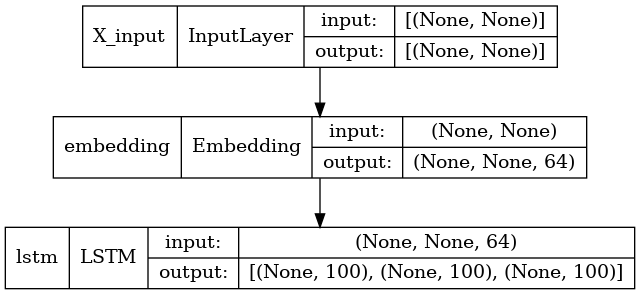

In [7]:
keras.utils.plot_model(outer_encoder, show_shapes=True)

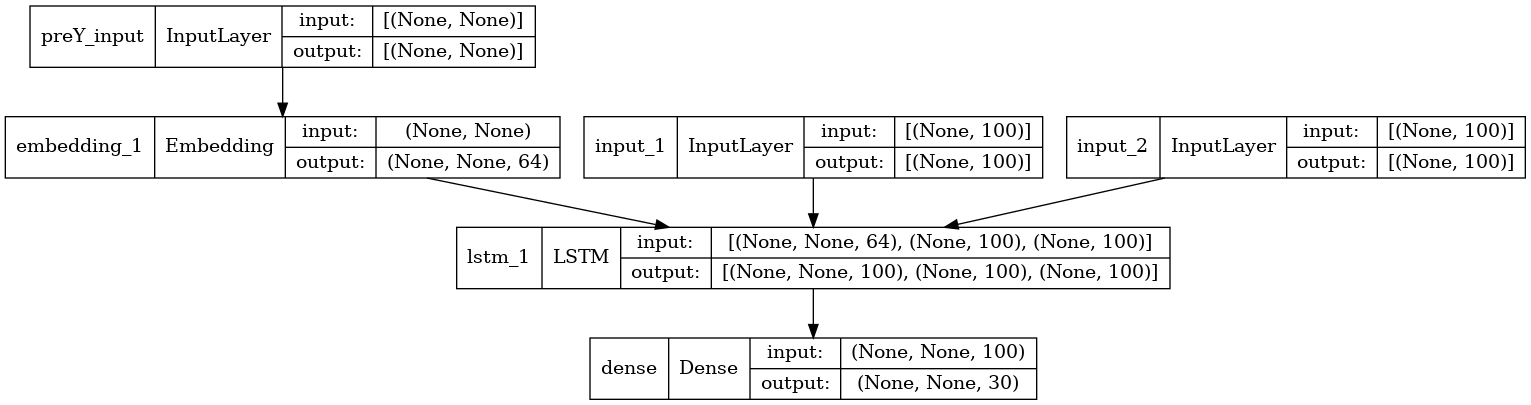

In [8]:
keras.utils.plot_model(outer_decoder, show_shapes=True)

# Load Input Data

In [9]:
# corpus = open('../data/len5_10000-train.txt')#corpus = np.loadtxt(sys.argv[1], dtype=object)
# corpus = np.loadtxt(corpus, dtype=object)

# trainingSet = open('../data/SG-10-train.txt')
# testingSet  = open('../data/SG-10-test.txt')

# trainingSet = np.loadtxt(trainingSet, dtype=str)
# testingSet  = np.loadtxt(testingSet, dtype=str)


# Load training and testing data

# corpus = np.loadtxt(sys.argv[1], dtype=object)
# trainingSet = np.loadtxt(sys.argv[2], dtype=object)
# testingSet  = np.loadtxt(sys.argv[3], dtype=object)


#corpus = np.loadtxt(sys.argv[1], dtype=object)
corpus = (Path('..') / 'data' / 'len5_10000-train.txt' ).open() #open('../data/len5_10000-train.txt')
corpus = np.loadtxt(corpus, dtype=object)

trainingSet = (Path('..') / 'data' / 'SG-10-train.txt').open()
testingSet  = (Path('..') / 'data' / 'SG-10-test.txt').open()

trainingSet = np.loadtxt(trainingSet, dtype=str)
testingSet  = np.loadtxt(testingSet, dtype=str)
#This is the same accross all files

# Create Embeddings

In [10]:
# This is following the LSTM_LSTM file
# Ask about this. It seems that the embeddings go with the outer from my observation.
# Otherwise there is just something strange about the code that is causeing LSTM/LSTM to be different

In [11]:
# --- Create a dictionary for all the letters & start/stops ---
alphabet = np.array([i for i in range(1, 31)]) # All letters plus STARTSENTENCE, STOPSENTENCE, start, stop
mapping = dict()
for i in range(len(alphabet) - 4):
    mapping[chr(ord('a') + i)] = alphabet[i]

mapping['start'] = alphabet[26]
mapping['stop']  = alphabet[27]
mapping['STARTSETNENCE'] = alphabet[28]
mapping['STOPSENTENCE']  = alphabet[29]

In [12]:
# --- Map words from corpus to words to roles ---
encoded_mapping = {}
selected_words = {}
for letter in string.ascii_lowercase[:10]:
    # Store the letter with the word for use in testing
    rand_corpus_word = random.choice(corpus)

    word, Y, preY, postY = word_to_int(rand_corpus_word, mapping)
    
    selected_words[letter] = postY
    
    encoded_mapping[letter] = outer_encoder.predict(np.array([word]))

In [13]:
#--- Pre input to make encodings at the sentence level --- 
roles   = trainingSet #argv[2]    
x_train = []
for sentence in roles:
    x_train.append([encoded_mapping[letter] for letter in sentence])
x_train = np.array(x_train) # shape (n, 3, 2, 1, 50)

LENGTH_IDK  = x_train.shape[-1] # Replacing '50' in the code

t1 = x_train[:,:,0,0,:] # new shape (n,3,50)
t2 = x_train[:,:,1,0,:] # " '' "
# 4 time steps. pre
pre_t1 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t1), axis = 1) # Orig. (x_train.shape[0], 1, 50)
pre_t2 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t2), axis = 1)
post_t1 = np.concatenate((t1, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)
post_t2 = np.concatenate((t2, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)

#looking at this I think that t1 is training and t2 is testing???
#But the LSTM/LSTM seems to use both of them????

In [15]:
# Start or stop tokens
s_s = {"start": [0,1], "stop": [1,0], "none": [0,0]}
pre_start = np.zeros((x_train.shape[0], 4, 2))
post_stop = np.copy(pre_start)
pre_start[:,0,:] = s_s["start"]
post_stop[:,3,:] = s_s["stop"]

#This is the same accross every file

In [49]:
print("shapes:")
print("\n\tx_train: ", x_train.shape)

print("\n\tpre_t1: ", pre_t1.shape)
print("\tpre_t2: ", pre_t2.shape)

print("\n\tpost_t1: ", post_t1.shape)
print("\tpost_t2: ", post_t2.shape)

print("\n\tpre_start: ", pre_start.shape)
print("\tpost_stop: ", post_stop.shape)

shapes:

	x_train:  (200, 3, 2, 1, 100)

	pre_t1:  (200, 4, 100)
	pre_t2:  (200, 4, 100)

	post_t1:  (200, 4, 100)
	post_t2:  (200, 4, 100)

	pre_start:  (200, 4, 2)
	post_stop:  (200, 4, 2)


# Inner Transformer

In [16]:
#Now I'm working from the Transformer_Transformer file

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [18]:
# --- Model parameters ---
length = 10
padded_length = 20

In [19]:
# Note we are making these the same, but they don't -have- to be!
input_length = padded_length
output_length = padded_length

In [20]:
# Vocabulary sizes...
encoder_vocab_size = 30 # a, b, c, ... z, start, stop, STARTSENTENCE, STOPSENTENCE
decoder_vocab_size = 30 # a, b, c, ... z, start, stop, STARTSENTENCE, STOPSENTENCE

In [21]:
# Size of the gestalt, context representations...
embed_dim = 128  # Embedding size for each token (enc/dec inputs already embedded)
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
stack = 1
wd = 0.01

In [22]:
HIDDEN_SIZE = 300
BATCH_SIZE  = 50
EPOCHS      = 250

In [56]:
# --- Construct inner encoder/decoder ---
with strategy.scope():
    # Encoder
    #The next two lines are what you need to look at.
    #encoder_input = keras.layers.Input(shape=(None,) + x_train.shape[2:], name="inner_enc_token")
    
    #These three are from LSTM/LSTM
    encoder_input_t1 = keras.layers.Input(shape=(None, t1.shape[2]), name="enc_token_1")
    encoder_input_t2 = keras.layers.Input(shape=(None, t1.shape[2]), name="enc_token_2")
    encoder_input = keras.layers.Concatenate()([encoder_input_t1, encoder_input_t2])

    
    #encoder_reshape = keras.layers.Reshape((-1,1500))(encoder_input)

    encoder_embedding = keras.layers.Dense(embed_dim)(encoder_input)

    encoder_mask_pos_embedding = InnerMaskedPositionEmbedding(maxlen=input_length,
                                                              embed_dim=encoder_embedding.shape[-1])(encoder_embedding)

    encoder_state = InnerTransformerBlock(embed_dim=encoder_embedding.shape[-1], 
                                          num_heads=num_heads,ff_dim=ff_dim)(encoder_mask_pos_embedding)
    
    encoder_model = keras.Model([encoder_input_t1, encoder_input_t2],encoder_state,name="InnerEncoder")
    
#keras.utils.plot_model(encoder_model, expand_nested=True, show_shapes=True)

    # Decoder
    #double check this junction as above (two input and a cat)
    # decoder_input = keras.layers.Input(shape=(None,) + pre_t1.shape[2:], name="inner_dec_token")
    
    #Again, from the LSTM/LSTM file (4 lines)
    decoder_input_t1 = keras.layers.Input(shape=(None, pre_t1.shape[2]), name="dec_token_1")
    decoder_input_t2 = keras.layers.Input(shape=(None, pre_t2.shape[2]), name="dec_token_2")
    #decoder_input_t3 = keras.layers.Input(shape=(None, 2), name="dec_start/stop")
    decoder_input = keras.layers.Concatenate()([decoder_input_t1, decoder_input_t2])#, decoder_input_t3])


    decoder_context_input = keras.layers.Input(shape=encoder_state.shape[1:], name='inner_enc_state')

    #decoder_reshape = keras.layers.Reshape((-1,1500))(decoder_input)

    decoder_startstop = keras.layers.Input(shape=(None, 2), name="dec_start/stop")

    decoder_concat = keras.layers.Concatenate()([decoder_input, decoder_startstop])

    decoder_embedding = keras.layers.Dense(embed_dim)(decoder_concat)

    decoder_mask_pos_embedding = InnerMaskedPositionEmbedding(maxlen=pre_t1.shape[1],
                                                         embed_dim=decoder_embedding.shape[-1])(decoder_embedding)

    decoder_block = InnerMaskedTransformerBlock(embed_dim=decoder_mask_pos_embedding.shape[-1],
                                           num_heads=num_heads,
                                           ff_dim=ff_dim)

    decoder_hidden_output = decoder_block([decoder_mask_pos_embedding, decoder_context_input])

    #x = keras.layers.Dense(post_t1.shape[2]*embed_dim)(decoder_hidden_output)

    #pay attention to this too
    # First tho do a dense layer to project from imbeddim to 200
    # Suggested as making the reshape 2,100
    # Then make a lambda layer to make this 2 100 layers
    
    #inner_output_reshape = keras.layers.Reshape((-1,post_t1.shape[-2],embed_dim))(x)

    #decoder_dense_t1 = keras.layers.Dense(post_t1.shape[-1], activation='linear', name="output_token")(inner_output_reshape)
    
    #decoder_split = keras.layers.Lambda(lambda x: tf.split(x, 2, axis=2))(x)
    decoder_dense_t1 = keras.layers.Dense(post_t1.shape[-1], activation='linear')(decoder_hidden_output)
    decoder_dense_t2 = keras.layers.Dense(post_t2.shape[-1], activation='linear')(decoder_hidden_output)
    #I think I leave this alone
    decoder_dense_startstop = keras.layers.Dense(2, activation='sigmoid', name="start/stop")(decoder_hidden_output)
    
    
    #moved the following line for better organization. Was above. 
    decoder_inputs = [decoder_context_input, decoder_input_t1, decoder_input_t2, decoder_startstop]

    decoder_outputs = [decoder_dense_t1, decoder_dense_t2, decoder_dense_startstop]

    decoder_model = keras.Model(decoder_inputs,decoder_outputs,name="InnerDecoder")

#keras.utils.plot_model(decoder_model, expand_nested=True, show_shapes=True)
    
    # Tie encoder and decoder into one model
    # with strategy.scope():
    #model = keras.Model([encoder_input]+ decoder_inputs, decoder_outputs)
    coupled_inputs = [keras.layers.Input(encoder_model.inputs[0].shape[1:]),
                      keras.layers.Input(encoder_model.inputs[1].shape[1:]),
                      keras.layers.Input(decoder_model.inputs[1].shape[1:]),
                      keras.layers.Input(decoder_model.inputs[2].shape[1:]),
                      keras.layers.Input(decoder_model.inputs[3].shape[1:])]                     
    coupled_outputs = decoder_model([encoder_model(coupled_inputs[0:2])] + coupled_inputs[2:])
    model = keras.Model(coupled_inputs, coupled_outputs)

    # --- Compile and fit model ---
    model.compile(loss = [keras.losses.MSE,keras.losses.binary_crossentropy],
               optimizer=keras.optimizers.Adam(),
               metrics=['accuracy'])

    # model_input = {"inner_enc_token":x_train, "inner_dec_token":pre_t1,
    #                      "dec_start/stop":pre_start}
    # model_target = {"output_token":post_t1, "start/stop": post_stop}
    
    #This is from the LSTM/LSTM model and I think it's the actual goal
    model_input = {"enc_token_1": t1, "enc_token_2": t2, "dec_token_1": pre_t1, "dec_token_2": pre_t2, "dec_start/stop": pre_start}
    model_target = {"token_1": post_t1, "token_2": post_t2, "start/stop": post_stop}

    #with strategy.scope():
    #history = model.fit([x_train,pre_t1, pre_start], [post_t1,post_stop],
    history = model.fit([t1,t2,pre_t1,pre_t2,pre_start],
                        [post_t1, post_t2, post_stop],
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         verbose=0)


2022-08-08 23:28:56.096855: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_21845"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:182"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 50
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

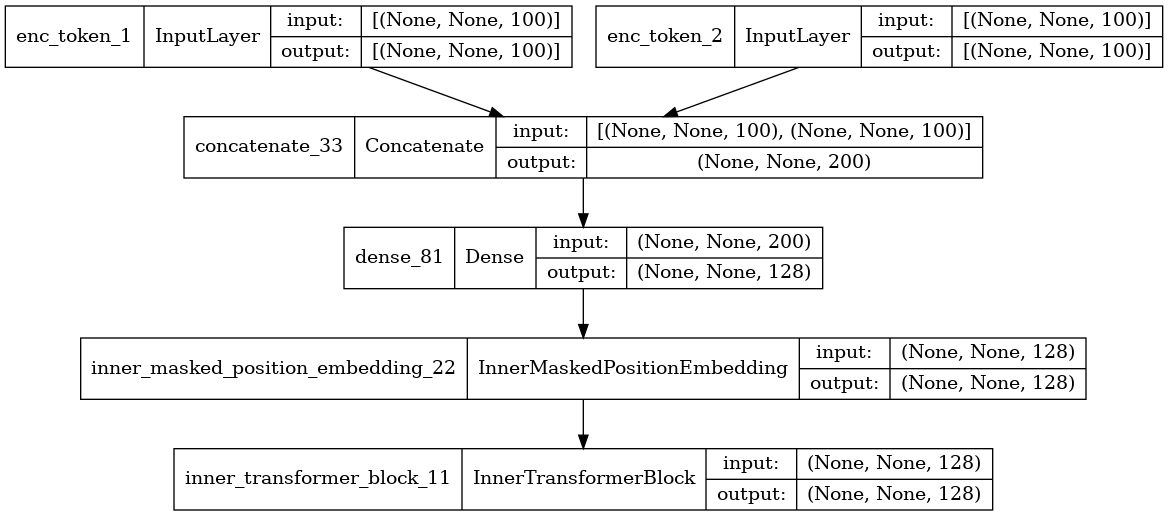

In [57]:
keras.utils.plot_model(encoder_model, expand_nested=True, show_shapes=True)

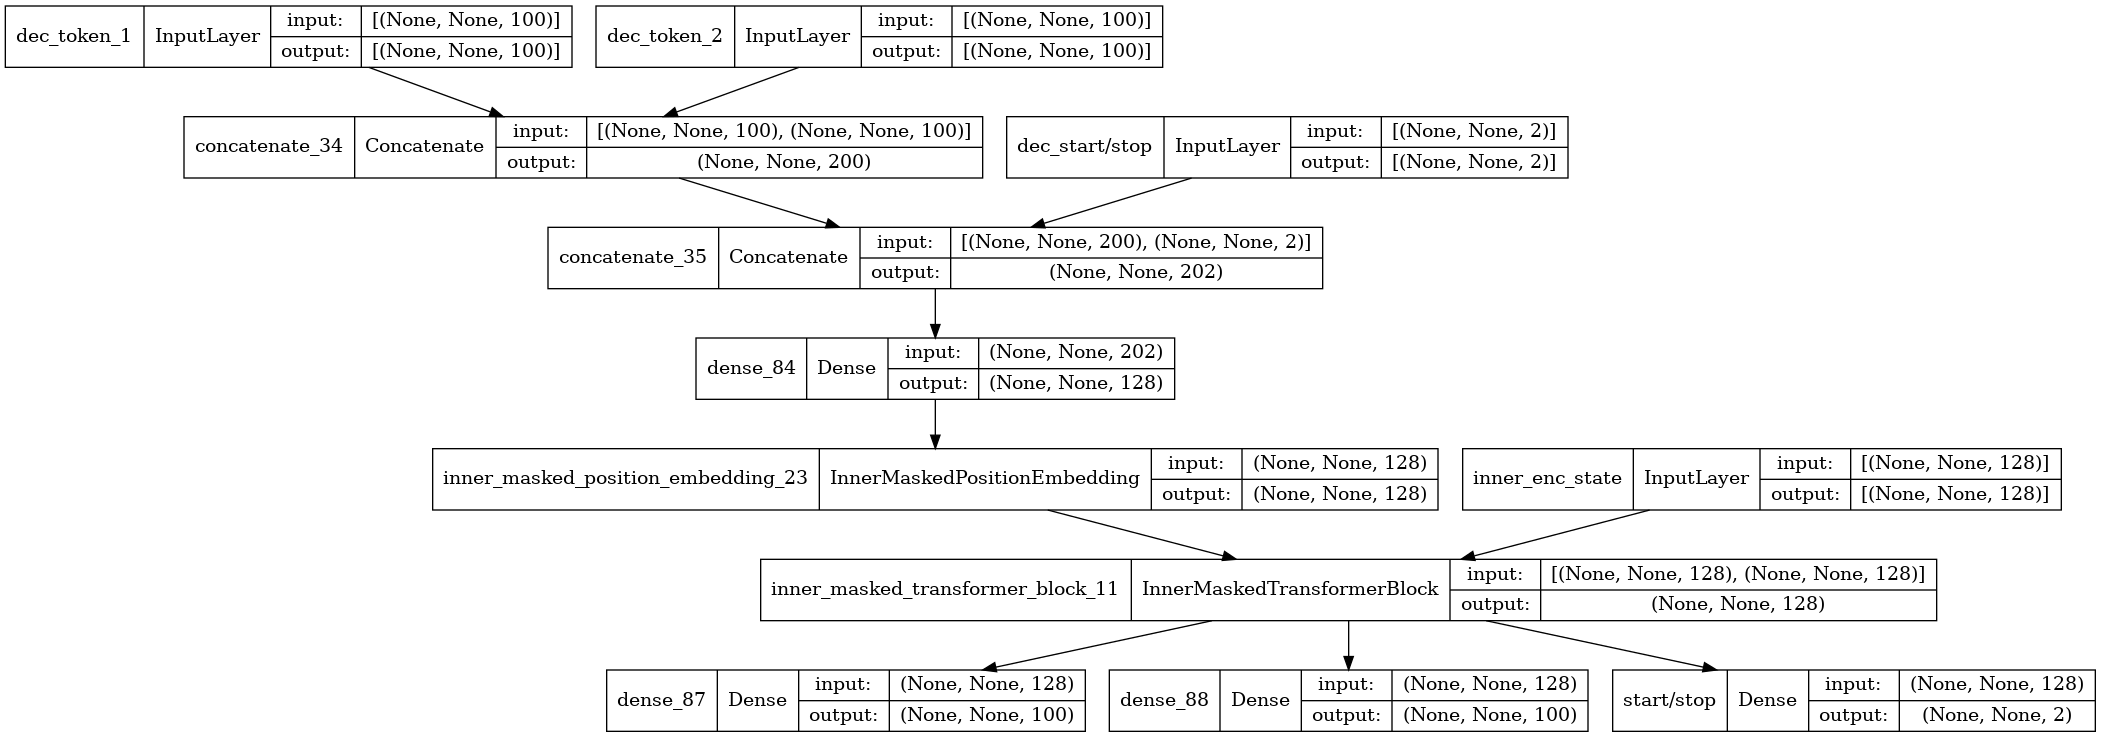

In [58]:
keras.utils.plot_model(decoder_model, expand_nested=True, show_shapes=True)

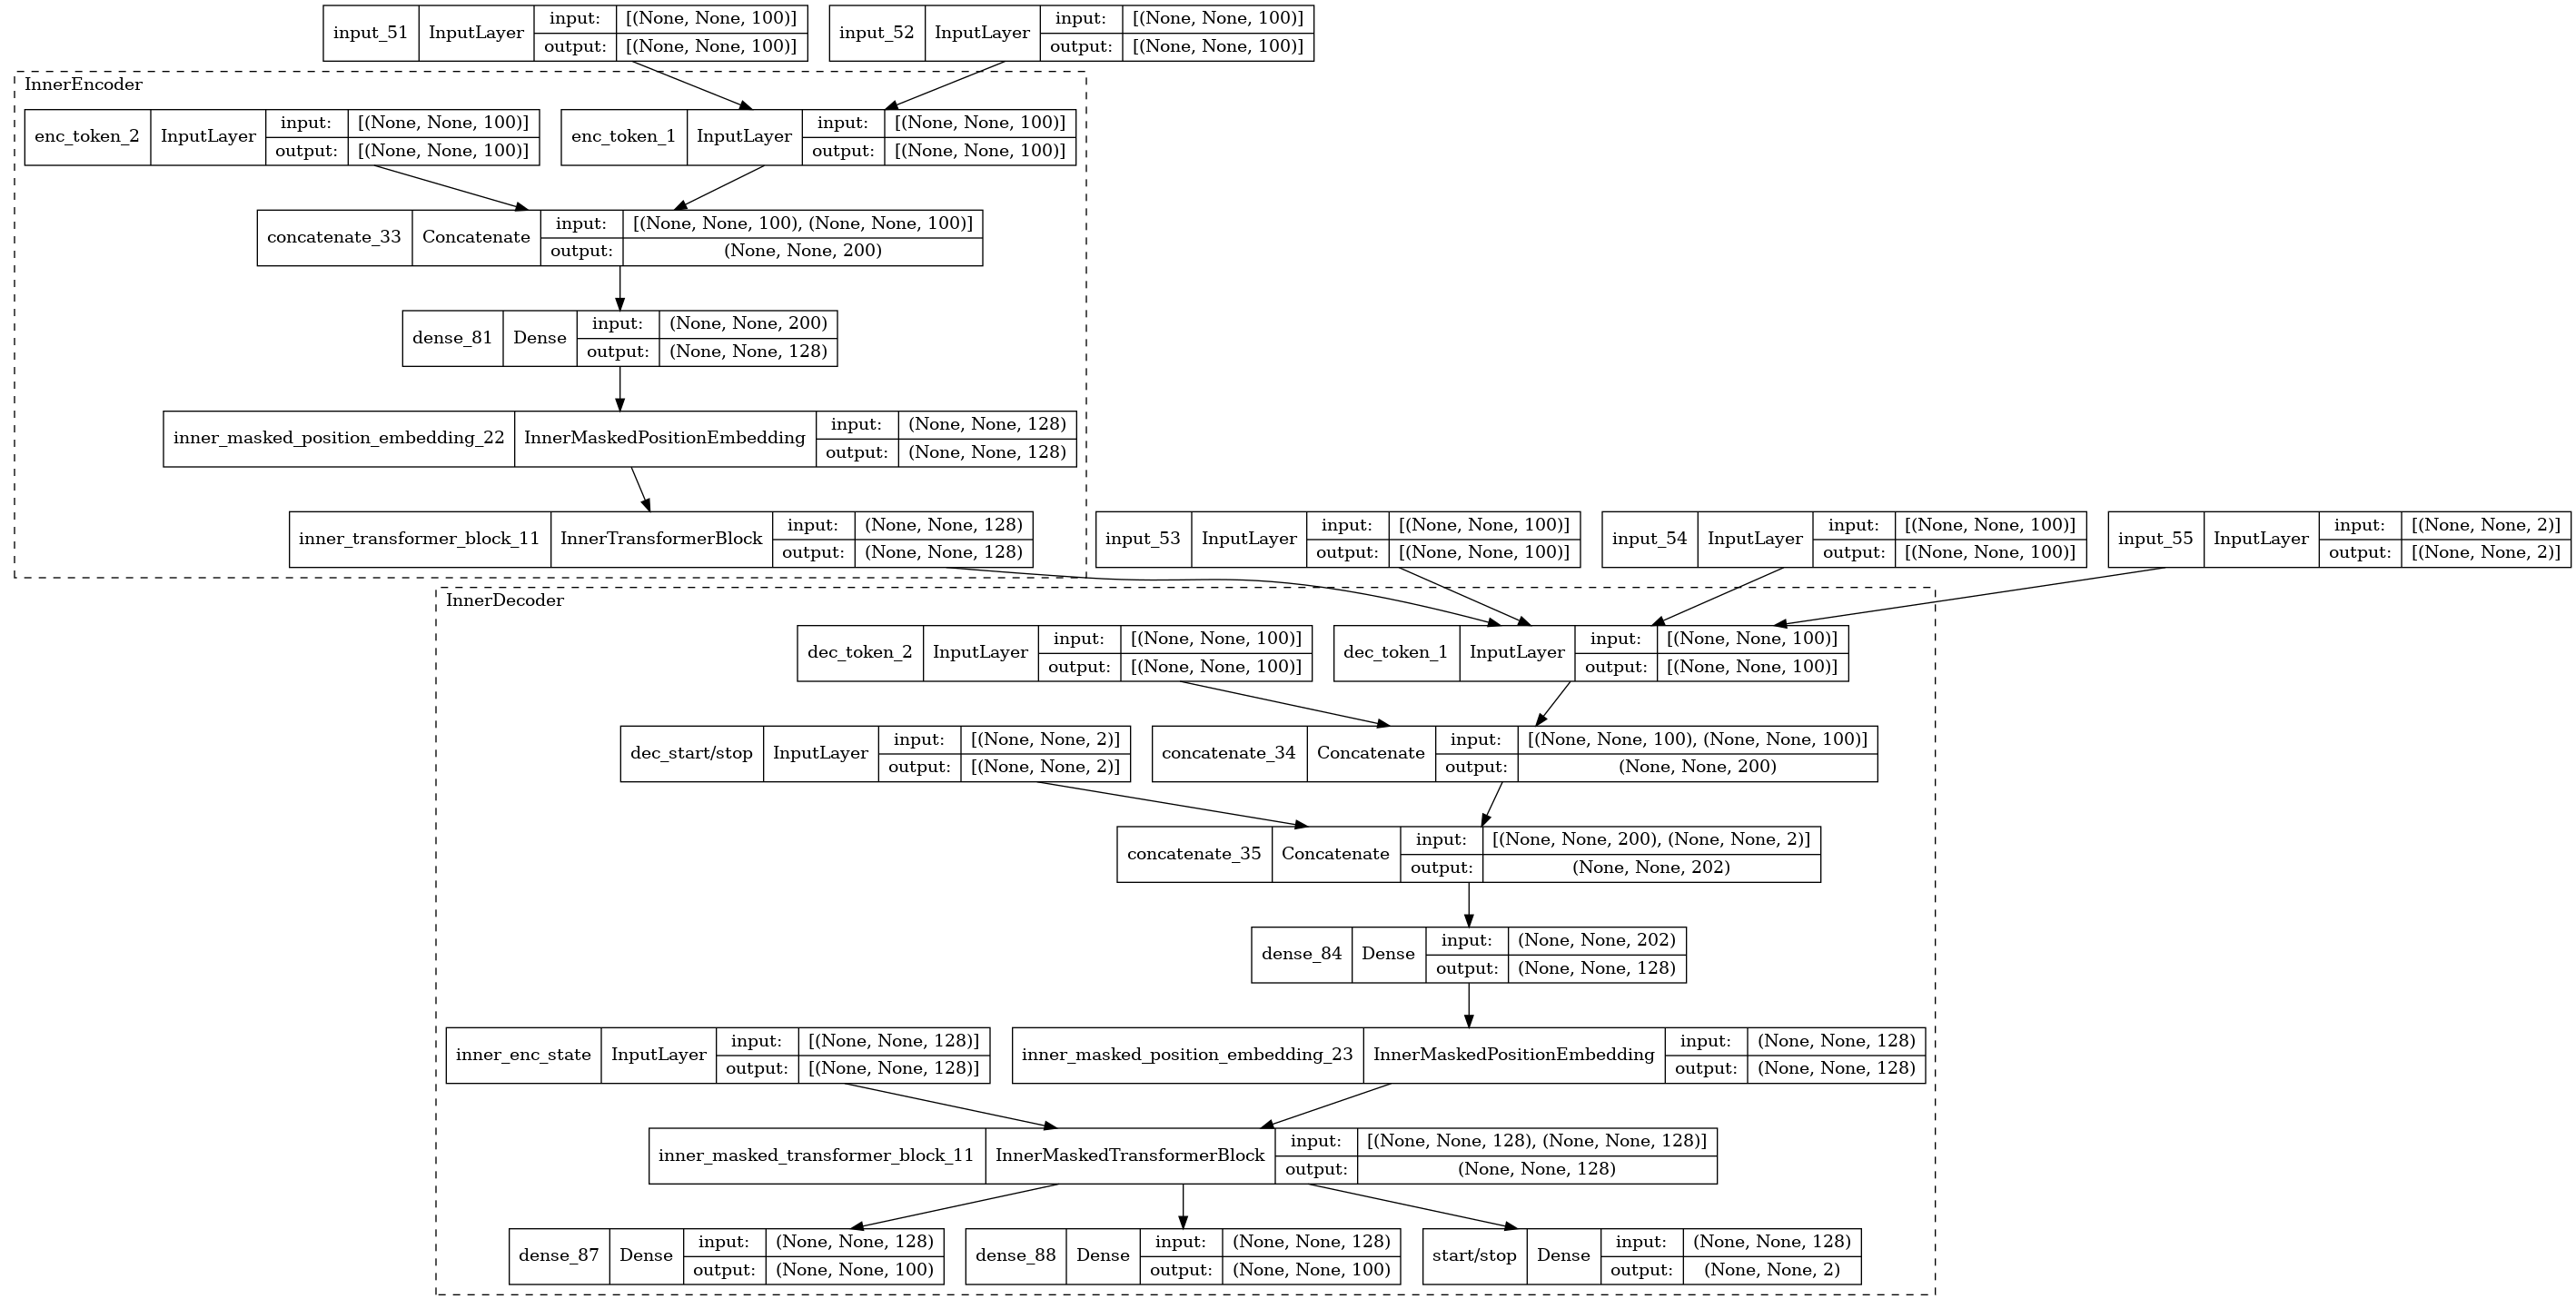

In [59]:
keras.utils.plot_model(model, expand_nested=True, show_shapes=True)